# Content
- Data prep
- Time-series analysis: decomposition
- Testing for stationarity
- Stationarizing x2

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

In [2]:
# import data
path = r'/Users/lennartzeidler/Desktop/Uni/(6) Advances Analytics and Dashboard Design/liquid store sales analysis'
sales = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'prepared_map_data.pkl'))

### Data prep

In [3]:
sales.head()

,Invoice/Item Number,Date,Store Name,Address,City,Zip Code,Store Location,Country,Category Name,Vendor Name,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
6,S28865700001,11/09/2015,Hy-Vee Food Store #3 / Waterloo,1422 FLAMMANG DR,WATERLOO,50702,"1422 FLAMMANG DR\nWATERLOO 50702\n(42.459938, ...",Black Hawk,DECANTERS & SPECIALTY PACKAGES,Duggan's Distillers Products Corp,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,6,104.58,9.0,2.38
8,S29339300091,11/30/2015,Hy-Vee Wine & Spirits / Muscatine,"522 MULBERRY, SUITE A",MUSCATINE,52761,"522 MULBERRY, SUITE A\nMUSCATINE 52761\n",Muscatine,DECANTERS & SPECIALTY PACKAGES,Jim Beam Brands,Laphroaig w/ Whiskey Stones,12,750,19.58,29.37,4,117.48,3.0,0.79
13,S28866900001,11/11/2015,"Spirits, Stogies and Stuff",118 South Main St.,HOLSTEIN,51025,118 South Main St.\nHOLSTEIN 51025\n(42.490073...,Ida,DECANTERS & SPECIALTY PACKAGES,Duggan's Distillers Products Corp,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,1,17.43,1.5,0.40
18,S29134300126,11/18/2015,J D Spirits Liquor,1023 9TH ST,ONAWA,51040,"1023 9TH ST\nONAWA 51040\n(42.025841, -96.095845)",Monona,CREAM LIQUEURS,MHW Ltd,"Rumchata ""GoChatas""",1,6000,99.00,148.50,1,148.50,6.0,1.59
21,S29282800048,11/23/2015,Hy-Vee Wine and Spirits / Pella,512 E OSKALOOSA,PELLA,50219,"512 E OSKALOOSA\nPELLA 50219\n(41.397023, -92....",Marion,DECANTERS & SPECIALTY PACKAGES,Duggan's Distillers Products Corp,Forbidden Secret Coffee Pack,6,1500,11.62,17.43,6,104.58,9.0,2.38


In [4]:
time_date = sales[['Date', 'Sale (Dollars)']]

In [5]:
time_date['datetime'] = pd.to_datetime(time_date['Date'])

In [6]:
time_date.drop(['Date'], axis=1, inplace=True)

In [7]:
time_date.head()

,Sale (Dollars),datetime
6,104.58,2015-11-09
8,117.48,2015-11-30
13,17.43,2015-11-11
18,148.50,2015-11-18
21,104.58,2015-11-23


#### Comment: 
I will create a dataset that only containes data for each month.

In [8]:
group_by_month = time_date.groupby(pd.Grouper(key='datetime', axis=0, 
                      freq='M')).mean()

In [9]:
group_by_month.head()

,Sale (Dollars)
datetime,
2012-01-31,108.025538
2012-02-29,115.930292
2012-03-31,113.290651
2012-04-30,121.705588
2012-05-31,115.788736


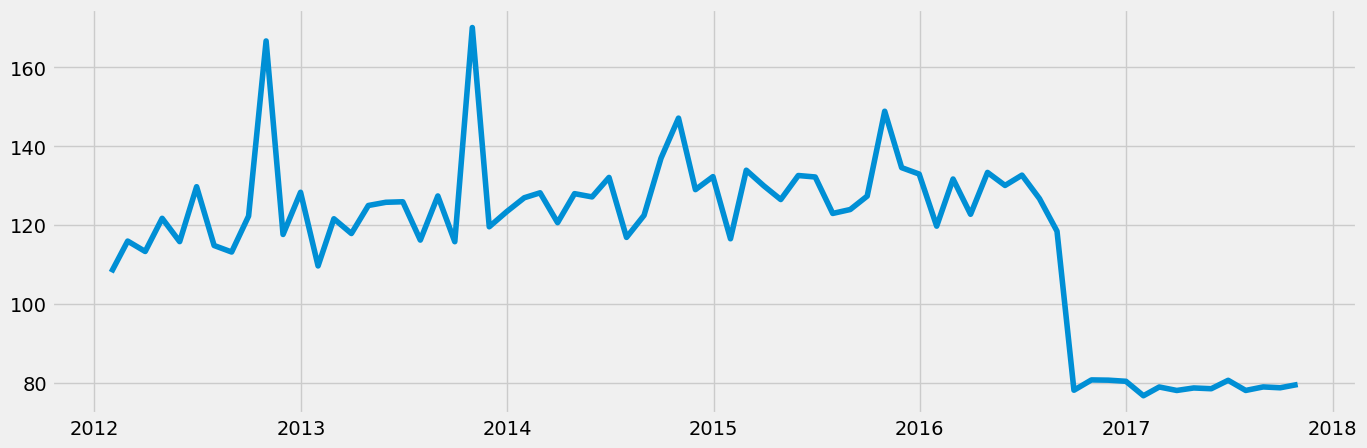

In [10]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(group_by_month)

In [11]:
# Check for missing values (you shouldn't have any)

group_by_month.isnull().sum() 

Sale (Dollars)    0
dtype: int64

In [12]:
dups = group_by_month.duplicated()
dups.sum()

0

### Time-series analysis: decomposition

In [13]:
decomposition = sm.tsa.seasonal_decompose(group_by_month, model='additive')

In [14]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

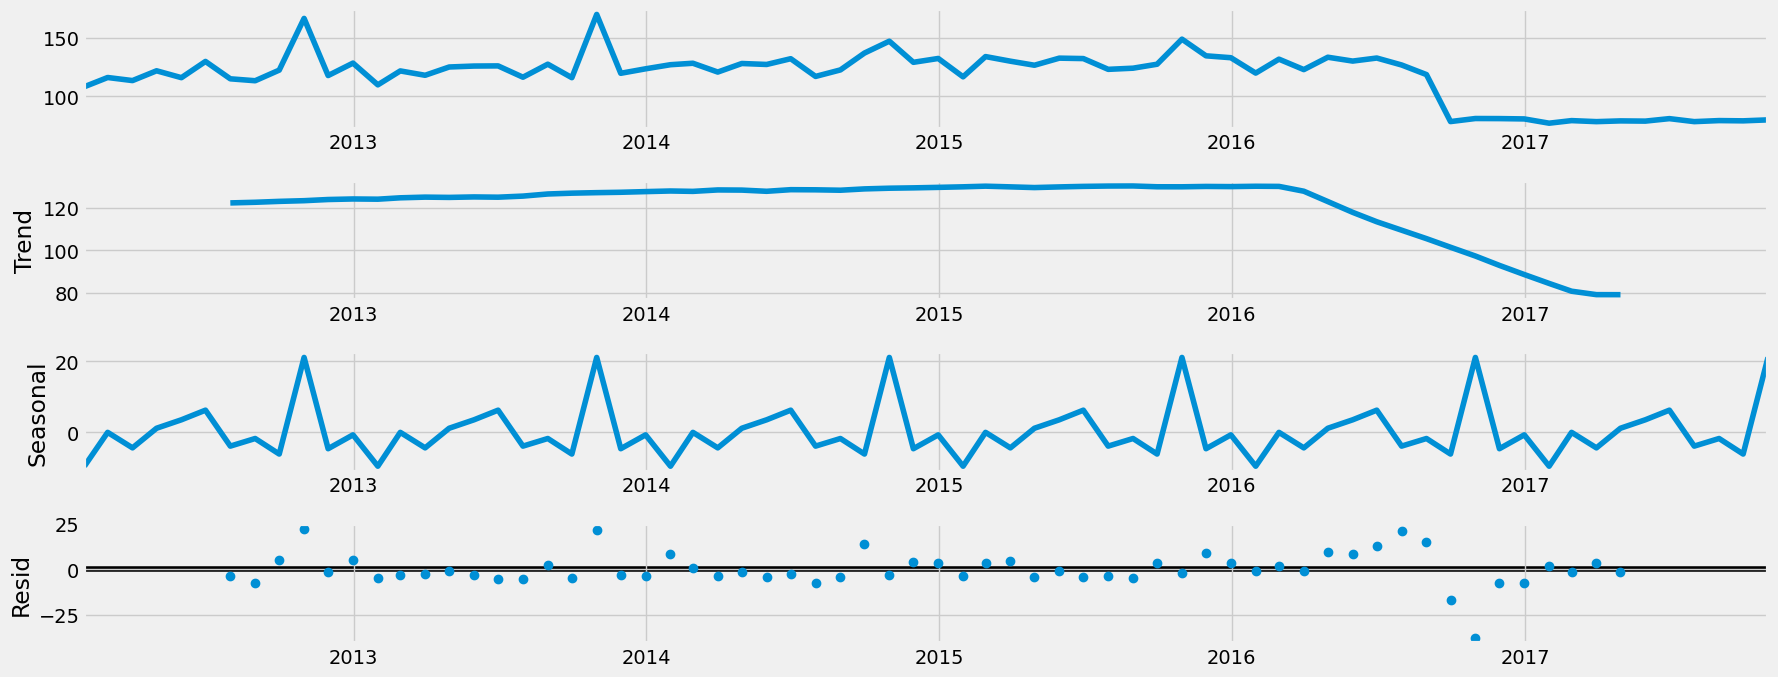

In [15]:
# Plot the separate components

decomposition.plot()
plt.show()

Even though the trend is smal there still is one. We also have a lo of noise and a seasonality. I could smothen the data more through grouping it by quater, but that would mean we lose a lot of data. 

### Testing for stationarity

In [16]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(group_by_month['Sale (Dollars)'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.395923
p-value                         0.584229
Number of Lags Used             1.000000
Number of Observations Used    68.000000
Critical Value (1%)            -3.530399
Critical Value (5%)            -2.905087
Critical Value (10%)           -2.590001
dtype: float64


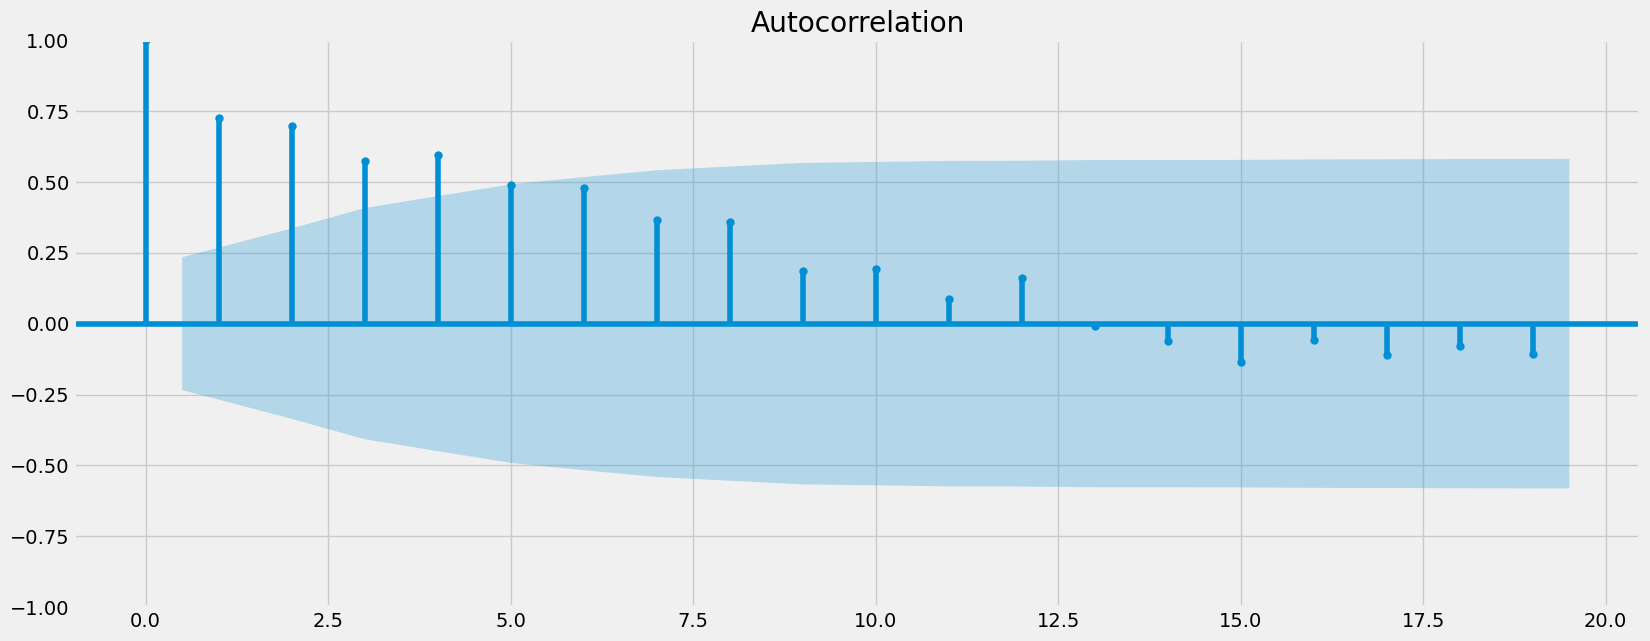

In [17]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(group_by_month)
plt.show()

The Autocorrelation looks all right but we have to stationarize the data, as a result of the Dickey-Fuller Stationarity test. The Test statistic value is bigger than any of the critical values.

### Stationarizing

In [18]:
# Log Transformations
group_by_month_diff = group_by_month - group_by_month.shift(1)

In [19]:
# droing new created null values
group_by_month_diff.dropna(inplace = True)

In [20]:
dickey_fuller(group_by_month_diff['Sale (Dollars)'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.046876
p-value                         0.266405
Number of Lags Used            11.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


The results are still not satisfying. Thats why I will conduct the same method again.

In [21]:
group_by_month_diff2 = group_by_month_diff - group_by_month_diff.shift(1)

In [22]:
group_by_month_diff2.dropna(inplace = True)

In [23]:
dickey_fuller(group_by_month_diff2['Sale (Dollars)'])

Dickey-Fuller Stationarity test:
Test Statistic                 -4.289556
p-value                         0.000463
Number of Lags Used            10.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64


Those results look way better now.

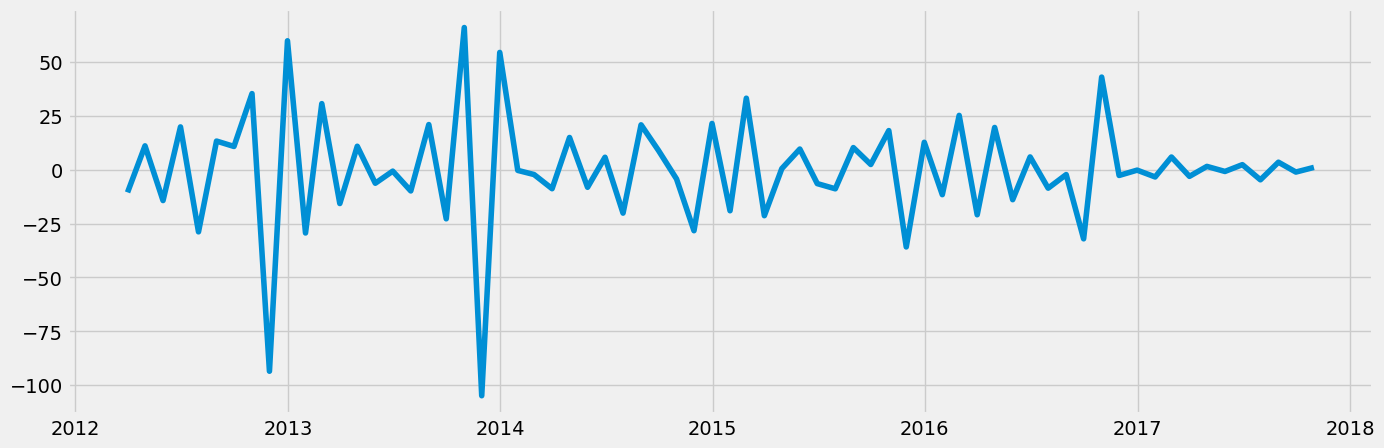

In [24]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(group_by_month_diff2)

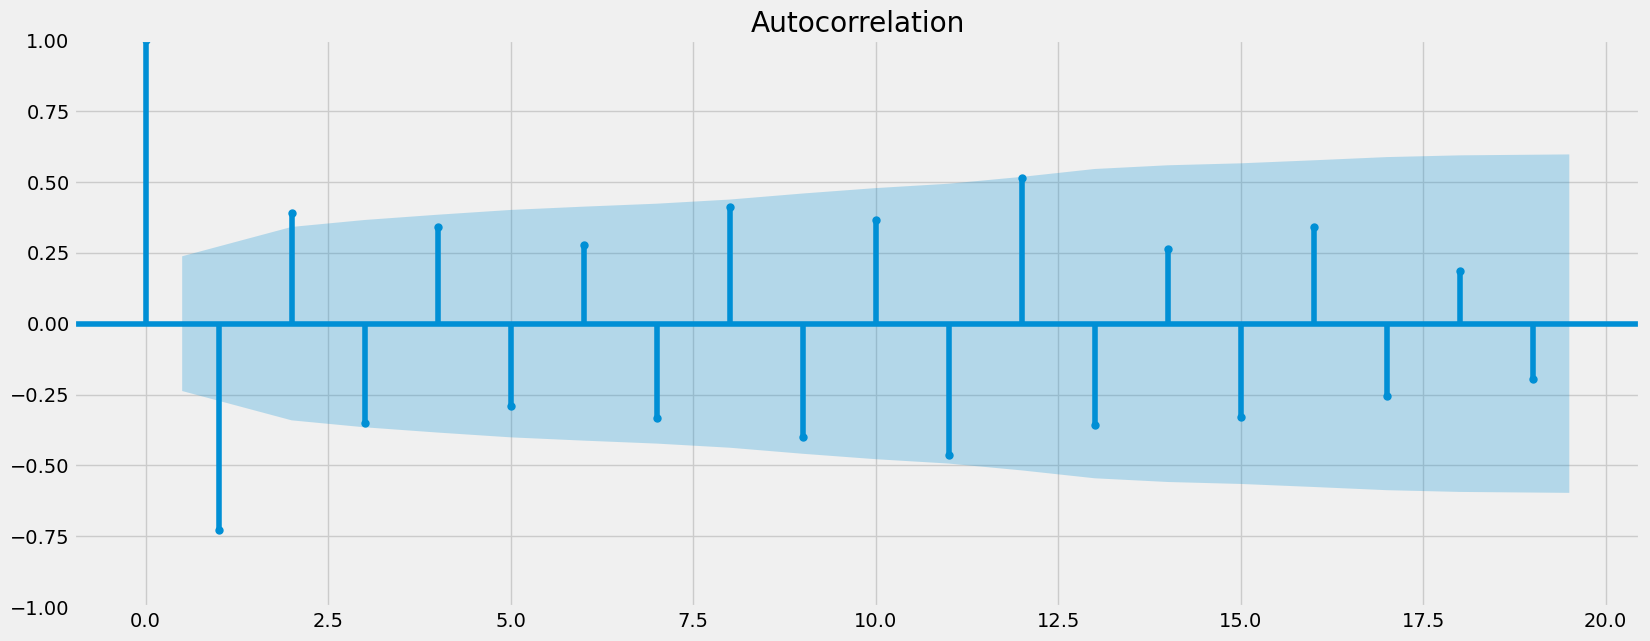

In [25]:
plot_acf(group_by_month_diff2)
plt.show()

Well the Autocorelation is critical but acceptable. 